change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

pipeline

MAE/MSE/RMSE

change lambda regu

In [76]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11086, done.
remote: Counting objects: 100% (11086/11086), done.
remote: Compressing objects: 100% (11071/11071), done.
remote: Total 11086 (delta 42), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11086/11086), 174.83 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images/facial_beauty_perception/FBP5500/Images


In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.models import Model

seed = 42

In [78]:
image_size = (90, 90)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_df = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_df['score'].to_numpy().tolist()

In [79]:
scores_df.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


(array([  4.,   5.,   2.,   9.,   8.,   9.,  25.,  27.,  48.,  66.,  93.,
        150., 146., 245., 232., 330., 388., 371., 419., 359., 270., 225.,
        167., 171., 138., 106., 128., 124., 165., 124., 163., 181., 144.,
        137., 119.,  79.,  75.,  32.,  11.,   5.]),
 array([1.016667  , 1.11000032, 1.20333365, 1.29666697, 1.3900003 ,
        1.48333362, 1.57666695, 1.67000028, 1.7633336 , 1.85666692,
        1.95000025, 2.04333358, 2.1366669 , 2.23000022, 2.32333355,
        2.41666687, 2.5100002 , 2.60333353, 2.69666685, 2.79000017,
        2.8833335 , 2.97666682, 3.07000015, 3.16333347, 3.2566668 ,
        3.35000012, 3.44333345, 3.53666678, 3.6300001 , 3.72333342,
        3.81666675, 3.91000007, 4.0033334 , 4.09666673, 4.19000005,
        4.28333337, 4.3766667 , 4.47000002, 4.56333335, 4.65666668,
        4.75      ]),
 <a list of 40 Patch objects>)

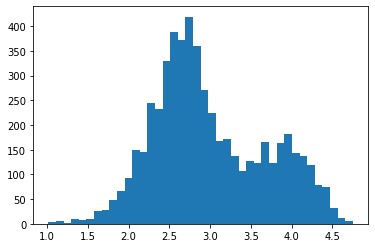

In [80]:
plt.hist(scores_df['score'], bins=40)

In [ ]:
images = []
for index in scores_df.index:
    img = image.load_img(scores_df['file_name'][index], target_size=image_size)
    img = image.img_to_array(img)
    images.append(img/255.)

In [ ]:
images = np.array(images)
scores = np.array(scores)

In [ ]:
print(images.shape)
print(scores.shape)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

In [ ]:
n_train = 4400
v_validation = 1100
buffer_size = 5500

In [ ]:
ds = ds.shuffle(buffer_size=buffer_size, seed=42)

In [ ]:
train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

val_ds1 = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds1 = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
def identity_block(X, f, filters, training=True, kernel_regularizer=None, dropout=False):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    kernel_regularizer -- to set up the weights regularization of a layer.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X, training=training)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X, training=training)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X, training=training)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [ ]:
def convolutional_block(X, f, filters, s=2, training=True, kernel_regularizer=None, dropout=False):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    kernel_regularizer -- to set up the weights regularization of a layer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X, training=training)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X, training=training)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5, training=training)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=kernel_regularizer)(X_shortcut)
    if dropout:
        X = Dropout(0.5, training=training)(X)     # <---- need training=training???
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(64, 64, 3), kernel_regularizer=None, dropout=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=kernel_regularizer)(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=kernel_regularizer)(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

In [ ]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
patience = 10
max_epochs = 90
steps_per_epoch = n_train//batch_size

In [ ]:
def get_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_nonregu_mae', patience=patience),
            tf.keras.callbacks.TensorBoard(logdir/name)
            ]

In [ ]:
def compile_and_fit(model, name, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=[tf.keras.losses.MeanAbsoluteError(
            name='nonregu_mae'
        )]
    )

    history = model.fit(
        train_ds1,
        steps_per_epoch=steps_per_epoch,
        epochs=max_epochs,
        validation_data=val_ds1,
        callbacks=get_callback(name),
    )

    return history

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

### Learning rate decay

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts, ExponentialDecay, InverseTimeDecay, PiecewiseConstantDecay

In [ ]:
cosine_decay = CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=steps_per_epoch * max_epochs,
    alpha=1/100,
    name='CosineDecay'
)

In [ ]:
cosine_decay_restarts = CosineDecayRestarts(
    initial_learning_rate=0.01,
    first_decay_steps=steps_per_epoch,
    alpha=1/100,
    t_mul=1.5,
    m_mul=0.9,
    name='CosineDecayRestarts'
)

In [ ]:
inverse_time_decay = InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=steps_per_epoch/3,
    decay_rate=0.2,
    staircase=False,
    name='InverseTimeDecay'
)

In [ ]:
step = np.linspace(0, steps_per_epoch * max_epochs)

plt.figure(figsize=(20, 5))
i = 1
for scheduler in [cosine_decay, cosine_decay_restarts, inverse_time_decay]:
    lr = scheduler(step)
    plt.subplot(1, 3, i)
    i += 1
    plt.plot(step/steps_per_epoch, lr)
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.title(scheduler.name)
    _ = plt.ylabel('Learning rate')


In [ ]:
lr_histories = {}

In [ ]:
model = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/'lr/cosine_decay', ignore_errors=True)
optimizer = Adam(cosine_decay)

np.random.seed(seed)

lr_histories['cosine_decay'] = compile_and_fit(
    model,
    name='lr/cosine_decay',
    optimizer=optimizer
)

In [ ]:
model = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/'lr/cosine_decay_restarts', ignore_errors=True)
optimizer = Adam(cosine_decay_restarts)

np.random.seed(seed)

lr_histories['cosine_decay_restarts'] = compile_and_fit(
    model,
    name='lr/cosine_decay_restarts',
    optimizer=optimizer
)

In [ ]:
model = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/'lr/inverse_time_decay', ignore_errors=True)
optimizer = Adam(inverse_time_decay)

np.random.seed(seed)

lr_histories['inverse_time_decay'] = compile_and_fit(
    model,
    name='lr/inverse_time_decay',
    optimizer=optimizer
)

In [ ]:
plotter.plot(lr_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 3])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Regularizations

In [23]:
regularization_histories = {}

In [ ]:
model_regu_dropout = ResNet50(input_shape=(*image_size, 3), kernel_regularizer='l2', dropout=True)

shutil.rmtree(logdir/'regularizations/regu_dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu_dropout'] = compile_and_fit(
    model_regu_dropout,
    name='regularizations/regu_dropout',
    optimizer='adam',
)

In [ ]:
model_raw = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/'regularizations/raw', ignore_errors=True)

np.random.seed(seed)

regularization_histories['raw'] = compile_and_fit(
    model_raw,
    name='regularizations/raw',
    optimizer='adam',
)

In [ ]:
model_regu = ResNet50(input_shape=(*image_size, 3), kernel_regularizer='l2')

shutil.rmtree(logdir/'regularizations/regu', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu'] = compile_and_fit(
    model_regu,
    name='regularizations/regu',
    optimizer='adam',
)

In [ ]:
model_dropout = ResNet50(input_shape=(*image_size, 3), dropout=True)

shutil.rmtree(logdir/'regularizations/dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['dropout'] = compile_and_fit(
    model_dropout,
    name='regularizations/dropout',
    optimizer='adam',
)

Text(0.5, 0, 'Epochs')

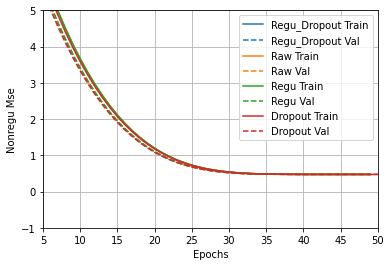

In [30]:
plotter.plot(regularization_histories)
# a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([-1, 5])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Optimizers

In [33]:
optimizer_histories = {}

In [35]:
shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)
shutil.copytree(logdir/"regularizations/raw", logdir/"optimizers/adam")

PosixPath('/tmp/tmprx6rvzt2/tensorboard_logs/optimizers/adam')

In [ ]:
# # ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# # NHỚ CHỈNH LẠI TÊN CÁC THỨ

# shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)

# model = ResNet50(input_shape=(*image_size, 3))

np.random.seed(seed)

# optimizer_histories['adam'] = compile_and_fit(
#     model,
#     name='optimizers/adam',
#     optimizer='adam'
# )

In [36]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/"optimizers/sgd_momentum", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_momentum'] = compile_and_fit(
    model,
    name='optimizers/sgd_momentum',
    optimizer=SGD(momentum=0.9)
)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/90
138/138 [==============================] - 39s 239ms/step - loss: 195.8649 - nonregu_mse: 195.1562 - val_loss: 0.4713 - val_nonregu_mse: 0.4740
Epoch 2/90
138/138 [==============================] - 32s 228ms/step - loss: 0.4757 - nonregu_mse: 0.4749 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 3/90
138/138 [==============================] - 32s 231ms/step - loss: 0.4756 - nonregu_mse: 0.4748 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 4/90
138/138 [==============================] - 32s 235ms/step - loss: 0.4756 - nonregu_mse: 0.4748 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 5/90
138/138 [==============================] - 33s 237ms/step - loss: 0.4756 - nonregu_mse: 0.4748 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 6/90
138/138 [==============================] - 32s 235ms/step - loss: 0.4756 - nonregu_mse: 0.4748 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 7/90
138/138 [==============================] - 33s 237ms/step - loss: 0.4756 - nonr

In [ ]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=(*image_size, 3))

shutil.rmtree(logdir/"optimizers/sgd_nesterov", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_nesterov'] = compile_and_fit(
    model,
    name='optimizers/sgd_nesterov',
    optimizer=SGD(momentum=0.9, nesterov=True)
)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/90
138/138 [==============================] - 40s 250ms/step - loss: 7.3105 - nonregu_mse: 7.2850 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 2/90
138/138 [==============================] - 33s 240ms/step - loss: 0.4751 - nonregu_mse: 0.4744 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 3/90
138/138 [==============================] - 33s 239ms/step - loss: 0.4751 - nonregu_mse: 0.4744 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 4/90
138/138 [==============================] - 33s 239ms/step - loss: 0.4751 - nonregu_mse: 0.4744 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 5/90
138/138 [==============================] - 33s 236ms/step - loss: 0.4751 - nonregu_mse: 0.4744 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 6/90
138/138 [==============================] - 31s 223ms/step - loss: 0.4751 - nonregu_mse: 0.4744 - val_loss: 0.4714 - val_nonregu_mse: 0.4741
Epoch 7/90
138/138 [==============================] - 33s 242ms/step - loss: 0.4751 - nonregu_

In [ ]:
plotter.plot(optimizer_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([-1, 5])
plt.xlabel('Epochs') # [Log scale]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/regularizations

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds1)).batch(batch_size)

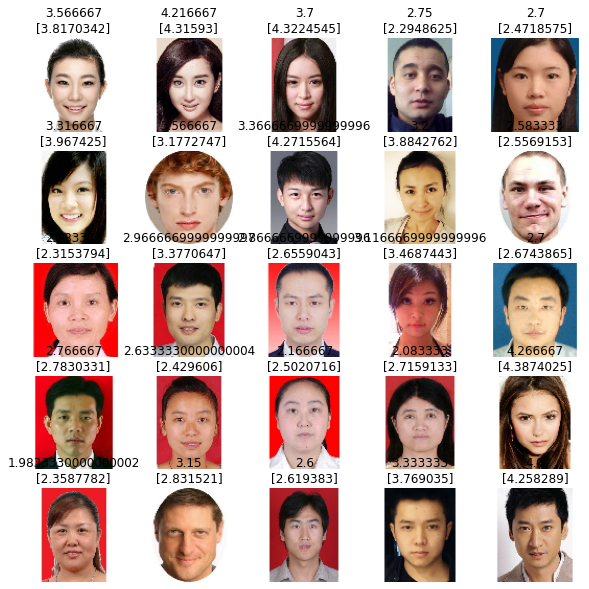

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds1.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.axis("off")